In [9]:
import sys
import math
import time
import random
sys.path.append("/github/meta_learning/np_variants/")

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (7.2, 4.8)

In [10]:
dtype = torch.double
device = torch.device("cuda")

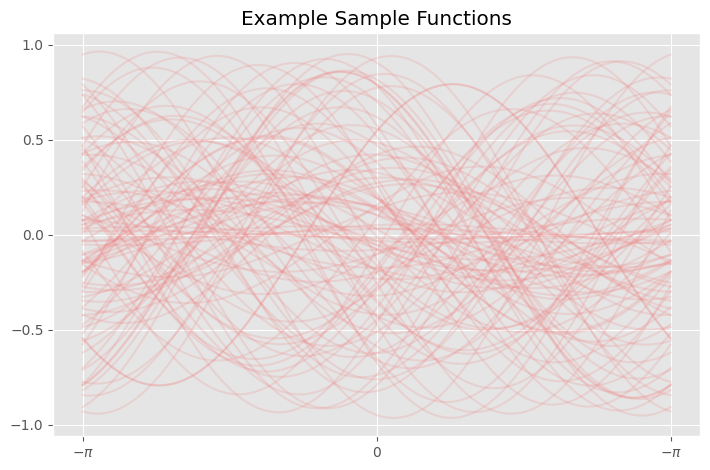

In [11]:
from data.functions_1d import SineFunc

func = SineFunc()
_, _, (amplitude, shift) = func.sample_data(num_tasks=100, num_samples=20)

for i in range(100):
    x = torch.linspace(-math.pi, math.pi, 200)
    y = amplitude[i] * torch.sin((x - shift[i]))
    plt.plot(x.detach().numpy(), y.detach().numpy(), color="lightcoral", alpha=0.2)

plt.xticks(ticks=[-math.pi, 0, math.pi], labels=[r"$-\pi$", r"0", r"$-\pi$"])
plt.yticks(ticks=[-1.0, -0.5, 0, 0.5, 1.0])
plt.title("Example Sample Functions")
plt.tight_layout()

In [12]:
from models.banp import BootstrappingAttentiveNeuralProcess
from models.loss_functions import bnp_loss_func
from utils import context_target_split

In [13]:
lr = 5e-4
batch_size = 16
num_samples = 200
num_epochs = 1000
print_epoch = 100

num_context_min = 3
num_context_max = 50
num_extra_target_min = 0
num_extra_target_max = 50

In [14]:
attn_types = ["laplace", "dot_product", "multihead"]
# attn_types = ["laplace"]
models = {attn_type: BootstrappingAttentiveNeuralProcess(x_dim=1, y_dim=1, attn_type=attn_type, self_attn=True).to(dtype=dtype, device=device) for attn_type in attn_types}
optimizers = {attn_type: optim.Adam(models[attn_type].parameters(), lr=lr) for attn_type in attn_types}
loss_func = bnp_loss_func

In [15]:
for attn_type in attn_types:
    model = models[attn_type]
    optimizer = optimizers[attn_type]
    print(f"ATTENTION TYPE: {attn_type}")
    start_time = time.time()
    for epoch in range(num_epochs):
        x_batch, y_batch, _ = func.sample_data(batch_size, num_samples)
        x_batch = x_batch.to(dtype=dtype, device=device)
        y_batch = y_batch.to(dtype=dtype, device=device)

        num_context = random.randint(num_context_min, num_context_max)
        num_extra_target = random.randint(num_extra_target_min, num_extra_target_max)

        x_context, y_context, x_target, y_target = context_target_split(x_batch, y_batch, num_context, num_extra_target)

        y_pred = model(x_context, y_context, x_target, y_target)
        
        optimizer.zero_grad()
        loss = loss_func(y_pred, y_target)
        loss.backward()
        optimizer.step()

        if (epoch+1) % print_epoch == 0:
            end_time = time.time()
            print(f"[{epoch+1}/{num_epochs}]\tLoss: {loss.item() / batch_size :.8f}\tTime: {end_time - start_time :.8f}")
            start_time = end_time
    print("==================================================================================================")

ATTENTION TYPE: laplace
[100/1000]	Loss: -0.02409936	Time: 7.67424178
[200/1000]	Loss: -0.15439904	Time: 7.73257518
[300/1000]	Loss: -1.23978236	Time: 7.75855780
[400/1000]	Loss: -2.43142635	Time: 8.79345274
[500/1000]	Loss: 0.79537853	Time: 8.31427550
[600/1000]	Loss: -3.28238841	Time: 8.43131900
[700/1000]	Loss: -3.36676305	Time: 8.82535267
[800/1000]	Loss: -2.01138468	Time: 8.21750116
[900/1000]	Loss: -3.72123764	Time: 8.40887380
[1000/1000]	Loss: -5.63293474	Time: 8.31617808
ATTENTION TYPE: dot_product
[100/1000]	Loss: 0.68995715	Time: 7.37033987
[200/1000]	Loss: -0.17529265	Time: 6.98893929
[300/1000]	Loss: -0.96140812	Time: 7.98778200
[400/1000]	Loss: -2.20305973	Time: 7.91561341
[500/1000]	Loss: -0.08696549	Time: 7.45071006
[600/1000]	Loss: -1.53558004	Time: 7.26769328
[700/1000]	Loss: -3.97504814	Time: 7.31180406
[800/1000]	Loss: -1.64817690	Time: 7.07389188
[900/1000]	Loss: -3.89377382	Time: 7.29992676
[1000/1000]	Loss: 0.00394815	Time: 7.72855043
ATTENTION TYPE: multihead
[10

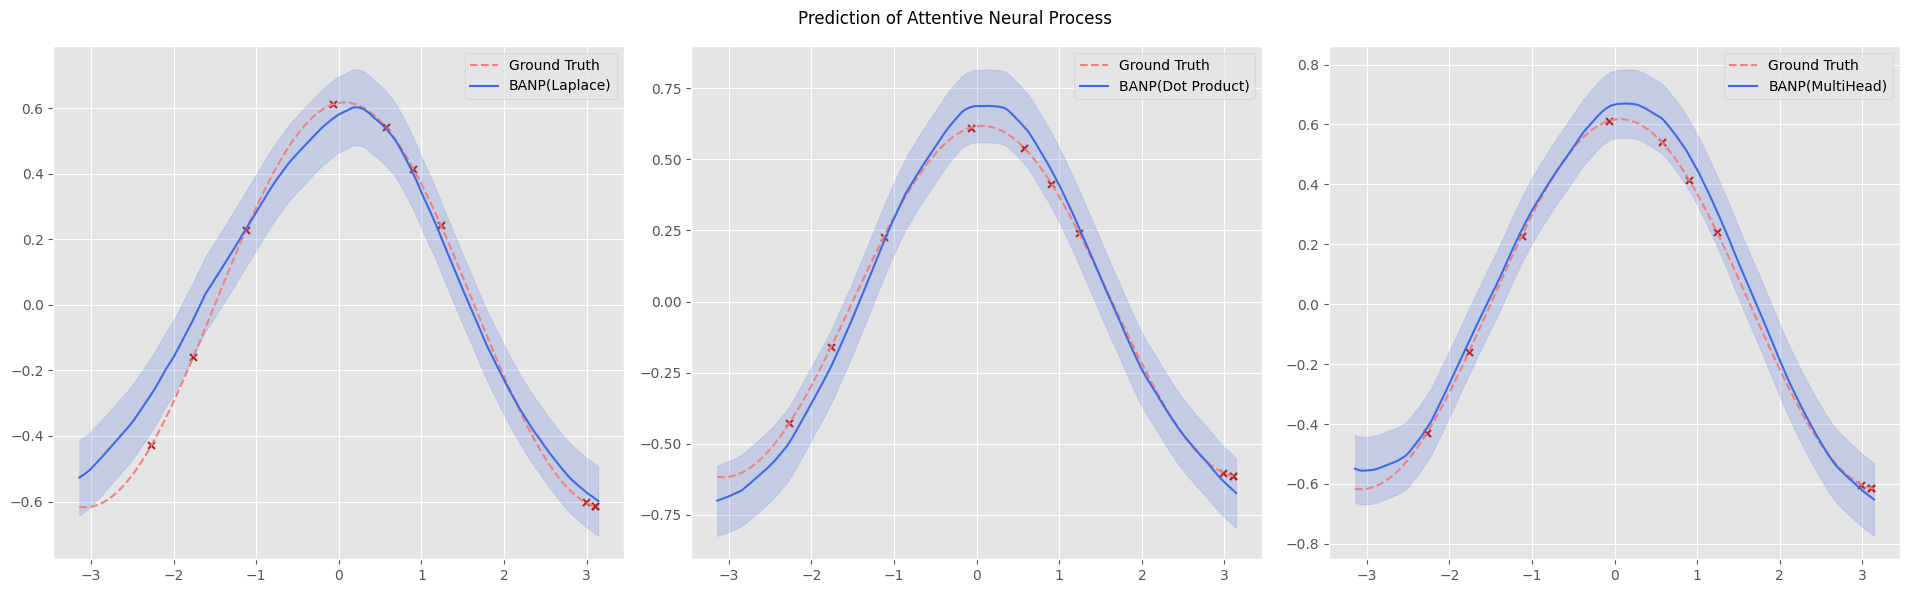

In [16]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(19.2, 6.0))

x_test, y_test, (amplitude, shift) = func.sample_data(num_tasks=1, num_samples=10)
x_grid = torch.linspace(-math.pi, math.pi, 1000)
y_grid = amplitude * torch.sin(x_grid - shift)

y_pred = [models[attn_type](x_test.to(dtype=dtype, device=device), 
                            y_test.to(dtype=dtype, device=device), 
                            x_grid.view(1, 1000, 1).to(dtype=dtype, device=device)) for attn_type in attn_types]

ax0.scatter(x_test.detach().numpy().flatten(), y_test.detach().numpy().flatten(), marker="x", s=25, color="firebrick", zorder=2)
ax0.plot(x_grid.detach().numpy(), y_grid.detach().numpy(), linestyle="--", color="lightcoral", label="Ground Truth")

ax0.plot(x_grid.detach().numpy(), y_pred[0].loc.cpu().detach().numpy().flatten(), color="royalblue", label="BANP(Laplace)")
ax0.fill_between(x_grid.detach().numpy(), y_pred[0].loc.cpu().detach().numpy().flatten() - y_pred[0].scale.cpu().detach().numpy().flatten(),
                                          y_pred[0].loc.cpu().detach().numpy().flatten() + y_pred[0].scale.cpu().detach().numpy().flatten(), color="royalblue", alpha=0.2)

ax1.scatter(x_test.detach().numpy().flatten(), y_test.detach().numpy().flatten(), marker="x", s=25, color="firebrick", zorder=2)
ax1.plot(x_grid.detach().numpy(), y_grid.detach().numpy(), linestyle="--", color="lightcoral", label="Ground Truth")

ax1.plot(x_grid.detach().numpy(), y_pred[1].loc.cpu().detach().numpy().flatten(), color="royalblue", label="BANP(Dot Product)")
ax1.fill_between(x_grid.detach().numpy(), y_pred[1].loc.cpu().detach().numpy().flatten() - y_pred[1].scale.cpu().detach().numpy().flatten(),
                                          y_pred[1].loc.cpu().detach().numpy().flatten() + y_pred[1].scale.cpu().detach().numpy().flatten(), color="royalblue", alpha=0.2)

ax2.scatter(x_test.detach().numpy().flatten(), y_test.detach().numpy().flatten(), marker="x", s=25, color="firebrick", zorder=2)
ax2.plot(x_grid.detach().numpy(), y_grid.detach().numpy(), linestyle="--", color="lightcoral", label="Ground Truth")

ax2.plot(x_grid.detach().numpy(), y_pred[2].loc.cpu().detach().numpy().flatten(), color="royalblue", label="BANP(MultiHead)")
ax2.fill_between(x_grid.detach().numpy(), y_pred[2].loc.cpu().detach().numpy().flatten() - y_pred[2].scale.cpu().detach().numpy().flatten(),
                                          y_pred[2].loc.cpu().detach().numpy().flatten() + y_pred[2].scale.cpu().detach().numpy().flatten(), color="royalblue", alpha=0.2)

ax0.legend()
ax1.legend()
ax2.legend()

plt.suptitle("Prediction of Attentive Neural Process")
plt.tight_layout()